In [1]:
import netCDF4
import pickle, pprint
import math
import netCDF4
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib
from scipy import stats
import pandas as pd
import xarray as xr
import dask
from tabulate import tabulate
import scipy
from mpl_toolkits.basemap import Basemap
bm = Basemap() 

/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


In [2]:
path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Preprocessed_Data/Final_Summer/full_physics_essentials_test_month02_targets.nc'
SPCAM5_ds = xr.open_dataset(path_to_file)

lons = SPCAM5_ds.lon.values
lats = SPCAM5_ds.lat.values

lats = lats[::144][:96]
lons = lons[:144]

path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Models/Final_Sherpa_DNN_Summer.nc'
SHERPA_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Models/Final_ReLU_DNN_Summer.nc'
CONSTRAINED_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Models/Final_Manual_DNN_Summer.nc'
UNCONSTRAINED_ds = xr.open_dataset(path_to_file)

path_to_file = '/fast/gmooers/Real_Geography_Manuscript/Models/Summer_3_Months_CAM5.nc'
CAM_ds = xr.open_dataset(path_to_file)

In [4]:
precip_SPCAM5_ds = np.squeeze(SPCAM5_ds.targets[:,-1].values)*86400000.

precip_SHERPA_ds = np.squeeze(SHERPA_ds.Prediction[:,-1].values)*86400000.

precip_CONSTRAINED_ds = np.squeeze(CONSTRAINED_ds.Prediction[:,-1].values)*86400000.

precip_UNCONSTRAINED_ds = np.squeeze(UNCONSTRAINED_ds.Prediction[:,-1].values)*86400000.

precip_cam_ds = (CAM_ds.PRECT.values)*86400000.

times = SPCAM5_ds.time.values

Xvar, Yvar = np.meshgrid(lons, lats)

x = 144
y = 96
z = 30
t = int(len(precip_SPCAM5_ds)/(x*y))
print(t)

8831


In [5]:
reconstructed_SPCAM5 = np.zeros(shape=(t, y, x))
reconstructed_SHERPA = np.zeros(shape=(t, y, x))
reconstructed_CONSTRAINED = np.zeros(shape=(t, y, x))
reconstructed_UNCONSTRAINED = np.zeros(shape=(t, y, x))


In [6]:
print(precip_SPCAM5_ds.shape)
print(precip_SHERPA_ds.shape)
print(precip_CONSTRAINED_ds.shape)
print(precip_UNCONSTRAINED_ds.shape)

(122079744,)
(122079744,)
(122079744,)
(122079744,)


In [7]:
count = 0
for i in range(t):
    for j in range(y):
        for k in range(x):
            reconstructed_SPCAM5[i,j,k] = precip_SPCAM5_ds[count]
            reconstructed_SHERPA[i,j,k] = precip_SHERPA_ds[count]
            reconstructed_CONSTRAINED[i,j,k] = precip_CONSTRAINED_ds[count]
            reconstructed_UNCONSTRAINED[i,j,k] = precip_UNCONSTRAINED_ds[count]
            count = count + 1
                

In [8]:
D = reconstructed_SHERPA.ravel()
T = reconstructed_SPCAM5.ravel()
C = precip_cam_ds.ravel()
CON = reconstructed_CONSTRAINED.ravel()
UCON = reconstructed_UNCONSTRAINED.ravel()

In [9]:
max_values = [np.nanmax(D), np.nanmax(T), np.nanmax(C)]
min_values = [np.nanmin(D),  np.nanmin(T),  np.nanmin(C)]
m = min(min_values)
M = max(max_values)

In [10]:
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_ReLU_DNN_Precip_Prediction.npy",CON)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Manual_DNN_Precip_Prediction.npy",UCON)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_DNN_Precip_Prediction.npy",D)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SPCAM5_Prepip_Truth.npy",T)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_CAM5_PRECIP.npy",C)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Precip_Max_Scalar.npy",m)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Precip_Min_Scalar.npy",M)

In [11]:
path_to_file = '/fast/gmooers/Raw_Data/extras/TimestepOutput_Neuralnet_SPCAM_216.cam.h0.2018-07.nc'
land_frac = xr.open_dataset(path_to_file)
land_f = np.squeeze(land_frac.LANDFRAC.values)

In [12]:
ocean_SHERPA = np.zeros(shape=(t, y, x))
ocean_SPCAM5 = np.zeros(shape=(t, y, x))
ocean_CONSTRAINED = np.zeros(shape=(t, y, x))
ocean_UNCONSTRAINED = np.zeros(shape=(t, y, x))
ocean_CAM5 = np.zeros(shape=(len(precip_cam_ds),y, x))

ocean_SHERPA[:,:,:] = np.nan
ocean_SPCAM5[:,:,:] = np.nan
ocean_CONSTRAINED[:,:,:] = np.nan
ocean_UNCONSTRAINED[:,:,:] = np.nan
ocean_CAM5[:,:,:] = np.nan

land_SHERPA = np.zeros(shape=(t, y, x))
land_SPCAM5 = np.zeros(shape=(t, y, x))
land_CONSTRAINED = np.zeros(shape=(t, y, x))
land_UNCONSTRAINED = np.zeros(shape=(t, y, x))
land_CAM5 = np.zeros(shape=(len(precip_cam_ds),y, x))

land_SHERPA[:,:,:] = np.nan
land_SPCAM5[:,:,:] = np.nan
land_CONSTRAINED[:,:,:] = np.nan
land_UNCONSTRAINED[:,:,:] = np.nan
land_CAM5[:,:,:] = np.nan

In [13]:
for i in range(len(reconstructed_SPCAM5[0])):
    for j in range(len(reconstructed_SPCAM5[0][0])):
        if land_f[i,j] >= 0.5:
            land_SPCAM5[:,i,j] = reconstructed_SPCAM5[:,i,j]
            land_SHERPA[:,i,j] = reconstructed_SHERPA[:,i,j]
            land_CONSTRAINED[:,i,j] = reconstructed_CONSTRAINED[:,i,j]
            land_UNCONSTRAINED[:,i,j] = reconstructed_UNCONSTRAINED[:,i,j]
            
        if land_f[i,j] < 0.5:
            ocean_SPCAM5[:,i,j] = reconstructed_SPCAM5[:,i,j]
            ocean_SHERPA[:,i,j] = reconstructed_SHERPA[:,i,j]
            ocean_CONSTRAINED[:,i,j] = reconstructed_CONSTRAINED[:,i,j]
            ocean_UNCONSTRAINED[:,i,j] = reconstructed_UNCONSTRAINED[:,i,j]
            
for i in range(len(precip_cam_ds[0])):
    for j in range(len(precip_cam_ds[0][0])):
        if land_f[i,j] >= 0.5:
            land_CAM5[:,i,j] = precip_cam_ds[:,i,j]
        if land_f[i,j] < 0.5:
            ocean_CAM5[:,i,j] = precip_cam_ds[:,i,j]

In [14]:
ocean_CAM5 = ocean_CAM5[np.logical_not(np.isnan(ocean_CAM5))]
land_CAM5 = land_CAM5[np.logical_not(np.isnan(land_CAM5))]

ocean_SPCAM5 = ocean_SPCAM5[np.logical_not(np.isnan(ocean_SPCAM5))]
land_SPCAM5 = land_SPCAM5[np.logical_not(np.isnan(land_SPCAM5))]

ocean_SHERPA = ocean_SHERPA[np.logical_not(np.isnan(ocean_SHERPA))]
land_SHERPA = land_SHERPA[np.logical_not(np.isnan(land_SHERPA))]

ocean_CONSTRAINED = ocean_CONSTRAINED[np.logical_not(np.isnan(ocean_CONSTRAINED))]
land_CONSTRAINED = land_CONSTRAINED[np.logical_not(np.isnan(land_CONSTRAINED))]

ocean_UNCONSTRAINED = ocean_UNCONSTRAINED[np.logical_not(np.isnan(ocean_UNCONSTRAINED))]
land_UNCONSTRAINED = land_UNCONSTRAINED[np.logical_not(np.isnan(land_UNCONSTRAINED))]

In [15]:
C_ocean = ocean_CAM5.ravel()
C_land = land_CAM5.ravel()

D_ocean = ocean_SHERPA.ravel()
D_land = land_SHERPA.ravel()

CON_ocean = ocean_CONSTRAINED.ravel()
CON_land = land_CONSTRAINED.ravel()

UCON_ocean = ocean_UNCONSTRAINED.ravel()
UCON_land = land_UNCONSTRAINED.ravel()

T_ocean = ocean_SPCAM5.ravel()
T_land = land_SPCAM5.ravel()

In [16]:
ocean_max_values = [np.nanmax(D_ocean), np.nanmax(T_ocean), np.nanmax(C_ocean)]
ocean_min_values = [np.nanmin(D_ocean),  np.nanmin(T_ocean),  np.nanmin(C_ocean)]
m_ocean = min(ocean_min_values)
M_ocean = max(ocean_max_values)
land_max_values = [np.nanmax(D_land), np.nanmax(T_land), np.nanmax(C_land)]
land_min_values = [np.nanmin(D_land),  np.nanmin(T_land),  np.nanmin(C_land)]
m_land = min(land_min_values)
M_land = max(land_max_values)

In [17]:
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_ReLU_Ocean_SPCAM5_Precip_Prediction.npy",CON_ocean)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Manual_Ocean_SPCAM5_Precip_Prediction.npy",UCON_ocean)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Ocean_SPCAM5_Precip_Prediction.npy",D_ocean)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Ocean_SPCAM5_Prepip_Truth.npy",T_ocean)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Ocean_CAM5_PRECIP.npy",C_ocean)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Ocean_Precip_Max_Scalar.npy",m_ocean)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Ocean_Precip_Min_Scalar.npy",M_ocean)

np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_ReLU_Land_SPCAM5_Precip_Prediction.npy",CON_land)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Manual_Land_SPCAM5_Precip_Prediction.npy",UCON_land)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_SHERPA_Land_SPCAM5_Precip_Prediction.npy",D_land)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Land_SPCAM5_Prepip_Truth.npy",T_land)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Land_CAM5_PRECIP.npy",C_land)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Land_Precip_Max_Scalar.npy",m_land)
np.save("/fast/gmooers/Real_Geography_Manuscript/Improved_Data_For_Paper/Final_Land_Precip_Min_Scalar.npy",M_land)


print("precip data saved")

precip data saved


In [18]:
def array_generator(min_val, max_val, percentage):
    listing = []
    for i in range(300):
        if i == 0:
            temp_val = min_val
            listing.append(temp_val)
        else:
            if temp_val < max_val:
                temp_val = temp_val*percentage
                listing.append(temp_val)
        
    print(len(listing))
    return np.array(listing)
#array_generator(0.03, maxi, 1.07)

In [19]:
fz = 15*1.5
lw = 4
siz = 100
XNNA = 1.25 # Abscissa where architecture-constrained network will be placed
XTEXT = 0.25 # Text placement
YTEXT = 0.3 # Text placement

plt.rc('text', usetex=False)
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
matplotlib.rcParams['lines.linewidth'] = lw

In [20]:
print(C == C_ocean)
print(T == T_ocean)

False
False


/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.
/export/home/gmooers/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


300


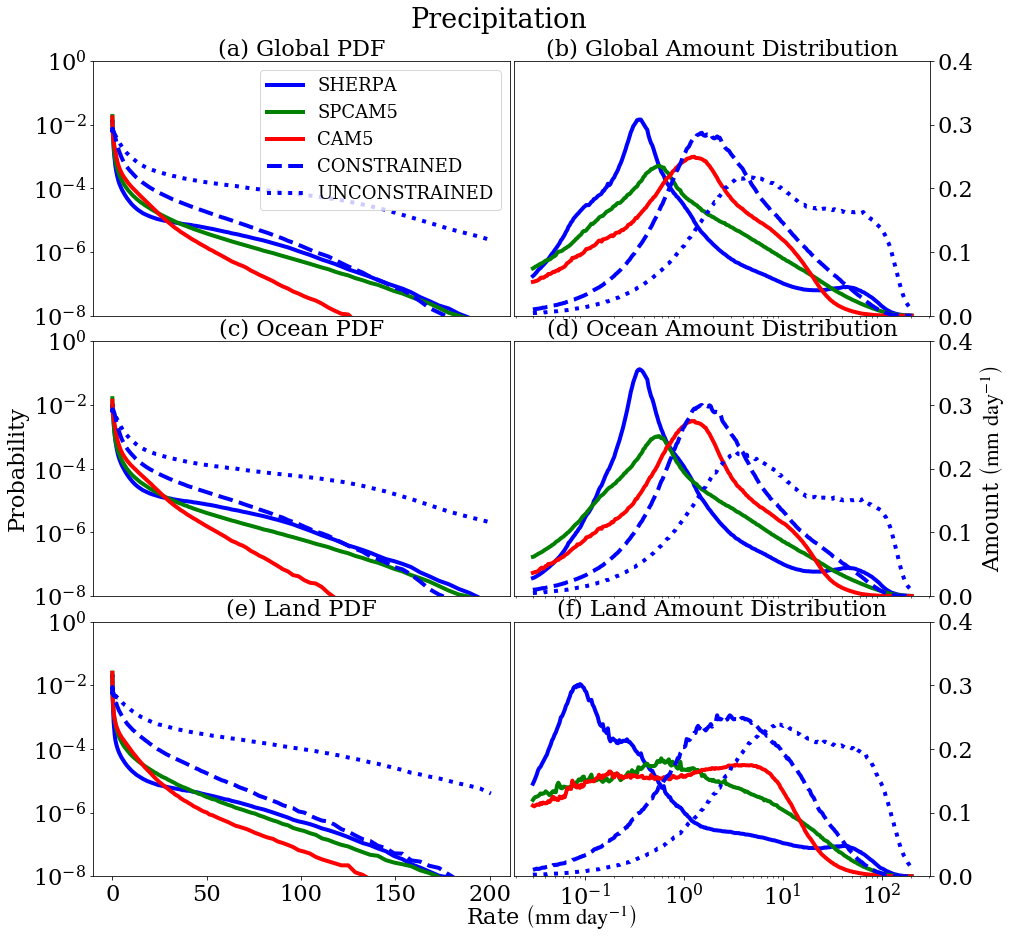

In [21]:
bins = array_generator(0.03, M, 1.03)



fig, ax = plt.subplots(3,2,figsize=(15,15))

shared_bins = np.histogram_bin_edges(D, bins=bins, range=(0, M))
freq, edges = np.histogram(D, bins = shared_bins, density=True)
#bad_freq, bad_edges = np.histogram(bad_feat, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C, bins = shared_bins, density=True)
freq_CON, edges_CON = np.histogram(CON, bins = shared_bins, density=True)
freq_UCON, edges_UCON = np.histogram(UCON, bins = shared_bins, density=True)

ax[0,1].set_xscale("log")
ax[1,1].set_xscale("log")
ax[2,1].set_xscale("log")

ax[0,0].plot(edges[:-1], freq/np.sum(freq),  label = "SHERPA", color = 'blue')
ax[0,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), label = "SPCAM5", color = 'green')
ax[0,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams), label = "CAM5", color = 'red')
ax[0,0].plot(edges_CON[:-1], freq_CON/np.sum(freq_CON), label = "CONSTRAINED", color = 'blue', linestyle='--')
ax[0,0].plot(edges_UCON[:-1], freq_UCON/np.sum(freq_UCON), label = "UNCONSTRAINED", color = 'blue', linestyle=':')
ax[0,0].set_ylim(1e-8, 1)

ax[2,0].set_xlabel('Rate '+r'$\left(\mathrm{mm \ day^{-1}}\right)$', fontsize = fz)
ax[2,0].xaxis.set_label_coords(1.1,-0.1)
ax[1,0].set_ylabel('Probability', fontsize = fz)
ax[0,0].set_title('(a) Global PDF', fontsize = fz)
ax[1,0].set_title('(c) Ocean PDF', fontsize = fz)
ax[2,0].set_title('(e) Land PDF', fontsize = fz)
ax[0,0].set_yscale('log')
ax[0,0].set_xticks([])
    
totals = freq*edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]
totals_CON = freq_CON*edges_CON[:-1]
totals_UCON = freq_UCON*edges_UCON[:-1]
    
ax[0,1].plot(edges[:-1], totals,  label = "SHERPA", color = 'blue')
ax[0,1].plot(edges_targ[:-1], totals_targ, label = "SPCAM5", color = 'green')
ax[0,1].plot(edges_cams[:-1], totals_cam, label = "CAM5", color = 'red')
ax[0,1].plot(edges_CON[:-1], totals_CON, label = "CONSTRAINED", color = 'blue', linestyle='--')
ax[0,1].plot(edges_UCON[:-1], totals_UCON, label = "UNCONSTRAINED", color = 'blue', linestyle=':')



ax[1,1].set_ylabel('Amount '+r'$\left(\mathrm{mm \ day^{-1}}\right)$', fontsize = fz)
ax[0,1].set_title('(b) Global Amount Distribution', fontsize = fz)
ax[1,1].set_title('(d) Ocean Amount Distribution', fontsize = fz)
ax[2,1].set_title('(f) Land Amount Distribution', fontsize = fz)
ax[0,0].legend(fontsize=fz*0.8, loc = 'best')

ax[0,1].yaxis.set_label_position("right")
ax[0,1].yaxis.tick_right()
ax[0,1].set_xticks([])
ax[0,1].set_ylim(0, 0.4)

shared_bins = np.histogram_bin_edges(D_ocean, bins=bins, range=(0, M))
freq, edges = np.histogram(D_ocean, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T_ocean, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C_ocean, bins = shared_bins, density=True)
freq_CON, edges_CON = np.histogram(CON_ocean, bins = shared_bins, density=True)
freq_UCON, edges_UCON = np.histogram(UCON_ocean, bins = shared_bins, density=True)

ax[1,0].plot(edges[:-1], freq/np.sum(freq), color = 'blue')
ax[1,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), color = 'green')
ax[1,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams),  color = 'red')
ax[1,0].plot(edges_CON[:-1], freq_CON/np.sum(freq_CON), color = 'b', linestyle='--')
ax[1,0].plot(edges_UCON[:-1], freq_UCON/np.sum(freq_UCON),  color = 'b', linestyle=':')
ax[1,0].set_xticks([])
ax[1,0].set_yscale('log')
ax[1,0].set_ylim(1e-8, 1)

totals = freq*edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]
totals_CON = freq_CON*edges_CON[:-1]
totals_UCON = freq_UCON*edges_UCON[:-1]

ax[1,1].plot(edges[:-1], totals, color = 'blue')
ax[1,1].plot(edges_targ[:-1], totals_targ, color = 'green')
ax[1,1].plot(edges_cams[:-1], totals_cam, color = 'red')
ax[1,1].plot(edges_CON[:-1], totals_CON, color = 'blue', linestyle='--')
ax[1,1].plot(edges_UCON[:-1], totals_UCON, color = 'blue', linestyle=':')
ax[1,1].set_xticks([])
ax[1,1].yaxis.set_label_position("right")
ax[1,1].yaxis.tick_right()
ax[1,1].set_ylim(0, 0.4)

shared_bins = np.histogram_bin_edges(D_land, bins=bins, range=(0, M))
freq, edges = np.histogram(D_land, bins = shared_bins, density=True)
freq_targ, edges_targ = np.histogram(T_land, bins = shared_bins, density=True)
freq_cams, edges_cams = np.histogram(C_land, bins = shared_bins, density=True)
freq_CON, edges_CON = np.histogram(CON_land, bins = shared_bins, density=True)
freq_UCON, edges_UCON = np.histogram(UCON_land, bins = shared_bins, density=True)

ax[2,0].plot(edges[:-1], freq/np.sum(freq), color = 'blue')
ax[2,0].plot(edges_targ[:-1], freq_targ/np.sum(freq_targ), color = 'green')
ax[2,0].plot(edges_cams[:-1], freq_cams/np.sum(freq_cams),  color = 'red')
ax[2,0].plot(edges_CON[:-1], freq_CON/np.sum(freq_CON), color = 'blue', linestyle='--')
ax[2,0].plot(edges_UCON[:-1], freq_UCON/np.sum(freq_UCON),  color = 'blue', linestyle=':')
ax[2,0].set_yscale('log')
ax[2,0].set_ylim(1e-8, 1)

totals = freq*edges[:-1]
totals_targ = freq_targ*edges_targ[:-1]
totals_cam = freq_cams*edges_cams[:-1]
totals_CON = freq_CON*edges_CON[:-1]
totals_UCON = freq_UCON*edges_UCON[:-1]

ax[2,1].plot(edges[:-1], totals, color = 'blue')
ax[2,1].plot(edges_targ[:-1], totals_targ, color = 'green')
ax[2,1].plot(edges_cams[:-1], totals_cam, color = 'red')
ax[2,1].plot(edges_CON[:-1], totals_CON, color = 'blue', linestyle='--')
ax[2,1].plot(edges_UCON[:-1], totals_UCON, color = 'blue', linestyle=':')
ax[2,1].yaxis.set_label_position("right")
ax[2,1].yaxis.tick_right()
ax[2,1].set_ylim(0, 0.4)
plt.suptitle("Precipitation", y=0.93)
plt.subplots_adjust(wspace=0.01, hspace=0.10)

#plt.savefig("Test_Figures/Annual_Precip_PDF.png")
#plt.savefig("Test_Figures/Annual_Precip_PDF.pdf")